<a href="https://colab.research.google.com/github/YinkaAjao/Probability-Distributions-Bayesian-Probability-and-Gradient-Descent-Implementation/blob/main/Part_1_Probability_Distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
PART 1: BIVARIATE NORMAL PDF (FROM SCRATCH)

import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load Dataset
def load_Earthquaketsunami_dataset(url="https://raw.githubusercontent.com/YinkaAjao/Probability-Distributions-Bayesian-Probability-and-Gradient-Descent-Implementation/main/earthquake_data_tsunami.csv"):

    try:
        df = pd.read_csv(url)
        print("Dataset loaded successfully.")
        return df
    except Exception as e:
        print("Error loading dataset:", e)
        raise
    return df

data = load_Earthquaketsunami_dataset()

data.head()

Dataset loaded successfully.


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [120]:
# Prepare Data

def prepare_data(df):
    """
    Clean and extract the required features.
    Drops missing values and ensures numeric type.

    Parameters:
    df (pd.DataFrame): The input DataFrame
    features (list): List of feature column names to extract

    Returns:
    numpy.ndarray: Cleaned feature matrix
    """

    features = ['magnitude', 'cdi']
    # Create a copy to avoid modifying the original DataFrame
    df_clean = df.copy()

    df_clean = df_clean.dropna(subset=features)
    for feature in features:
        df_clean[feature] = pd.to_numeric(df_clean[feature], errors='coerce')
    df_clean = df_clean.dropna(subset=features)

    X = [[float(row[features[0]]), float(row[features[1]])] for _, row in df_clean.iterrows()]

    print(f"Data prepared successfully. Number of points: {len(X)}")
    print(f"Features used: {features}")

    return X

In [121]:
# Compute Mean and Covariance Manually

def compute_mean(X):
    """Compute mean vector manually."""
    n = len(X)
    sum_x = 0.0
    sum_y = 0.0

    for point in X:
        sum_x += point[0]
        sum_y += point[1]

    return [float(sum_x / n), float(sum_y / n)]


def compute_covariance(X, mu):
    """Compute 2x2 covariance matrix manually."""
    n = len(X)
    cov_xx = 0.0
    cov_xy = 0.0
    cov_yy = 0.0

    for point in X:
        diff_x = float(point[0]) - mu[0]
        diff_y = float(point[1]) - mu[1]
        cov_xx += diff_x * diff_x
        cov_xy += diff_x * diff_y
        cov_yy += diff_y * diff_y

    # Sample covariance
    cov_xx /= (n - 1)
    cov_xy /= (n - 1)
    cov_yy /= (n - 1)

    return [[cov_xx, cov_xy], [cov_xy, cov_yy]]

In [122]:
# Manual Matrix Determinant and Inverse
def matrix_determinant_2x2(matrix):
    """Compute determinant of 2x2 matrix manually."""
    return matrix[0][0] * matrix[1][1] - matrix[0][1] * matrix[1][0]

def matrix_inverse_2x2(matrix):
    """Compute inverse of 2x2 matrix manually."""
    det = matrix_determinant_2x2(matrix)
    if det == 0:
        raise ValueError("Matrix is singular, cannot compute inverse")

    return [
        [matrix[1][1] / det, -matrix[0][1] / det],
        [-matrix[1][0] / det, matrix[0][0] / det]
    ]

# Manual Vector-Matrix Multiplication
def vector_matrix_multiply(vector, matrix):
    """Multiply 1x2 vector by 2x2 matrix manually."""
    result = [0.0, 0.0]
    result[0] = vector[0] * matrix[0][0] + vector[1] * matrix[1][0]
    result[1] = vector[0] * matrix[0][1] + vector[1] * matrix[1][1]
    return result

# Manual Dot Product
def dot_product(v1, v2):
    """Compute dot product of two vectors manually."""
    return v1[0] * v2[0] + v1[1] * v2[1]

In [123]:
# Manual Bivariate Normal PDF

def bivariate_normal_pdf(points, mu, cov):
    """Compute bivariate normal PDF manually using pure Python."""
    det_cov = matrix_determinant_2x2(cov)

    # Safety check for determinant. if negative, use absolute value
    # This can happen due to numerical precision issues with small datasets
    if det_cov <= 0:
        print(f"Warning: Determinant is non-positive ({det_cov}), using absolute value")
        det_cov = abs(det_cov)

    # Additional safety: ensure determinant is not too small
    if det_cov < 1e-10:
        det_cov = 1e-10

    inv_cov = matrix_inverse_2x2(cov)

    norm_const = 1.0 / (2.0 * math.pi * math.sqrt(det_cov))
    pdf_values = []

    for p in points:
        diff = [p[0] - mu[0], p[1] - mu[1]]
        temp = vector_matrix_multiply(diff, inv_cov)
        exponent = -0.5 * dot_product(diff, temp)
        pdf_values.append(norm_const * math.exp(exponent))

    return pdf_values


In [124]:
#Create Meshgrid for Plotting


def create_meshgrid(X, n_points=100, pad=5):
    """Create grid for contour and surface plots."""
    # Find min and max values
    x_values = [point[0] for point in X]
    y_values = [point[1] for point in X]

    x_min, x_max = min(x_values) - pad, max(x_values) + pad
    y_min, y_max = min(y_values) - pad, max(y_values) + pad

    # Create grid manually
    xx = []
    yy = []
    grid = []

    for i in range(n_points):
        x_row = []
        y_row = []
        for j in range(n_points):
            x_val = x_min + (x_max - x_min) * i / (n_points - 1)
            y_val = y_min + (y_max - y_min) * j / (n_points - 1)
            x_row.append(x_val)
            y_row.append(y_val)
            grid.append([x_val, y_val])
        xx.append(x_row)
        yy.append(y_row)

    return xx, yy, grid

# Reshape PDF values for plotting
def reshape_for_plotting(values, n_points):
    """Reshape 1D list to 2D grid for plotting."""
    zz = []
    for i in range(n_points):
        row = []
        for j in range(n_points):
            row.append(values[i * n_points + j])
        zz.append(row)
    return zz


In [125]:
# Visualization Functions

def plot_contour(X, xx, yy, zz, feature_names):
    """Plot contour of bivariate normal PDF."""
    plt.figure(figsize=(7,6))
    cont = plt.contour(xx, yy, zz, levels=12, cmap='viridis')
    x_data = [point[0] for point in X]
    y_data = [point[1] for point in X]
    plt.scatter(x_data, y_data, c='red', s=10, alpha=0.5, label="Data Points")
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title('Contour of Bivariate Normal PDF (From Scratch)')
    plt.legend()
    plt.clabel(cont, inline=1, fontsize=8)
    plt.show()


def plot_surface(xx, yy, zz, feature_names):
    """3D surface plot of the PDF."""
    import numpy as np  # Just for plotting

    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(np.array(xx), np.array(yy), np.array(zz),
                   cmap='viridis', alpha=0.8, edgecolor='none')
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel('PDF')
    ax.set_title('3D Surface of Bivariate Normal PDF (Pure From Scratch)')
    plt.show()


Dataset loaded successfully.
Data prepared successfully. Number of points: 782
Features used: ['magnitude', 'cdi']
Mean Vector: [6.941125319693102, 4.333759590792839]
Covariance Matrix:
  [ 0.19848272691251004 , 0.29593635282983577 ]
  [ 0.29593635282983577 , 10.048513120106296 ]
DEBUG: Determinant of covariance matrix: 1.9068779605686073

PDF calculated for all 782 data points
First 5 PDF values: ['0.058673', '0.114322', '0.102847', '0.083247', '0.040146']


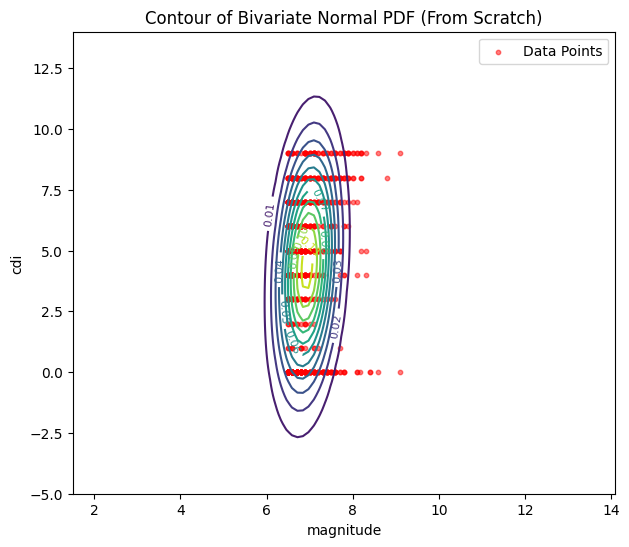

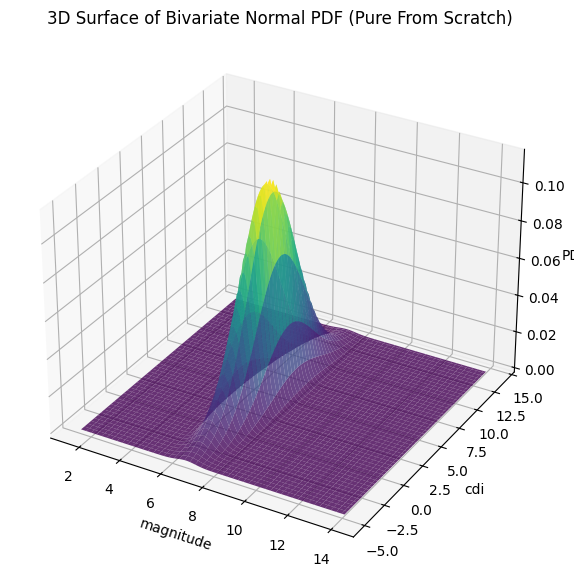

In [127]:
def main():
    # Step 1: Load dataset
    url = "https://raw.githubusercontent.com/YinkaAjao/Probability-Distributions-Bayesian-Probability-and-Gradient-Descent-Implementation/main/earthquake_data_tsunami.csv"
    df = load_Earthquaketsunami_dataset(url=url)

    # Step 2: Prepare features
    X = prepare_data(df)

    # Step 3: Compute mean and covariance manually
    mu = compute_mean(X)
    cov = compute_covariance(X, mu)
    print("Mean Vector:", mu)
    print("Covariance Matrix:")
    print("  [", cov[0][0], ",", cov[0][1], "]")
    print("  [", cov[1][0], ",", cov[1][1], "]")

    # DEBUG: Check the determinant
    det_cov = matrix_determinant_2x2(cov)
    print(f"DEBUG: Determinant of covariance matrix: {det_cov}")

    # Step 4: Calculate PDF for original data points
    data_point_pdfs = bivariate_normal_pdf(X, mu, cov)
    print(f"\nPDF calculated for all {len(X)} data points")
    print("First 5 PDF values:", [f"{val:.6f}" for val in data_point_pdfs[:5]])

    # Step 5: Create grid and evaluate PDF manually
    n_points = 100
    xx, yy, grid = create_meshgrid(X, n_points=n_points)
    grid_pdfs = bivariate_normal_pdf(grid, mu, cov)
    zz = reshape_for_plotting(grid_pdfs, n_points)

    # Step 6: Visualize results
    features = ['magnitude', 'cdi']
    plot_contour(X, xx, yy, zz, features)
    plot_surface(xx, yy, zz, features)


# Run the complete analysis
if __name__ == "__main__":
    main()

In [ ]:
PART 2

# PART 4
Implement gradient descent in Python using SciPy to update the parameters $m$ and $b$ of a linear equation $y = mx + b$ for 4 iterations, starting with initial values $m=-1$, $b=1$, and a learning rate of $\alpha=0.1$, using the data points $(1, 3)$ and $(3, 6)$. Compute the predicted values using the final parameters. Visualize the changes in $m$, $b$, and the Mean Squared Error (MSE) over the iterations using Matplotlib.

## Define the linear equation and initial parameters

### Subtask:
Define the linear equation $y = mx + b$ and initialize the values of $m$, $b$, and the learning rate $\alpha$.


**Reasoning**:
The subtask requires initializing the variables `m`, `b`, and `alpha`. This can be done directly in a code block.



In [ ]:
# Initialize parameters
m = -1
b = 1
alpha = 0.1

print(f"Initial m: {m}")
print(f"Initial b: {b}")
print(f"Learning rate (alpha): {alpha}")

Initial m: -1
Initial b: 1
Learning rate (alpha): 0.1


## Define the data points

### Subtask:
Define the given data points $(x, y)$.


**Reasoning**:
Define the x and y coordinates of the data points as NumPy arrays and print them.



In [ ]:
# Define data points (x, y)
import numpy as np
x = np.array([1, 3])
y = np.array([3, 6])

# Print the data points
print("x data points:", x)
print("y data points:", y)

x data points: [1 3]
y data points: [3 6]


## Implement the gradient descent function

### Subtask:
Create a function that iteratively updates $m$ and $b$ for a specified number of iterations.


**Reasoning**:
Define the gradient_descent function to iteratively update m and b and store the values and MSE over iterations.



In [ ]:
def gradient_descent(x, y, m, b, alpha, num_iterations):
    """
    Performs gradient descent to update m and b for a linear equation y = mx + b.

    Args:
        x (np.ndarray): Array of x values.
        y (np.ndarray): Array of y values.
        m (float): Initial value of the slope (m).
        b (float): Initial value of the intercept (b).
        alpha (float): Learning rate.
        num_iterations (int): Number of iterations for gradient descent.

    Returns:
        tuple: A tuple containing lists of m, b, and mse values over iterations.
    """
    m_history = []
    b_history = []
    mse_history = []

    for i in range(num_iterations):
        y_pred = m * x + b
        error = y - y_pred

        gradient_m = -2 * np.mean(x * error)
        gradient_b = -2 * np.mean(error)

        m = m - alpha * gradient_m
        b = b - alpha * gradient_b

        mse = np.mean(error**2)

        m_history.append(m)
        b_history.append(b)
        mse_history.append(mse)

    return m_history, b_history, mse_history

## Run the gradient descent

### Subtask:
Run the gradient descent function for the specified number of iterations.


**Reasoning**:
Define the number of iterations and call the gradient descent function to perform the updates.



In [ ]:
# Define the number of iterations
num_iterations = 4

# Run the gradient descent function
m_history, b_history, mse_history = gradient_descent(x, y, m, b, alpha, num_iterations)

# Print the history of m, b, and mse
print("m history:", m_history)
print("b history:", b_history)
print("MSE history:", mse_history)

m history: [np.float64(1.7000000000000002), np.float64(1.2599999999999998), np.float64(1.3399999999999999), np.float64(1.3336)]
b history: [np.float64(2.1), np.float64(1.9), np.float64(1.916), np.float64(1.8968)]
MSE history: [np.float64(36.5), np.float64(1.0400000000000016), np.float64(0.06400000000000004), np.float64(0.034815999999999944)]


## Print the final parameters and predictions

### Subtask:
Print the final values of $m$ and $b$, and the predicted values of $y$ using these final parameters.


**Reasoning**:
Print the final values of m and b, and the predicted values of y using these final parameters.



In [ ]:
# Get the final values of m and b
final_m = m_history[-1]
final_b = b_history[-1]

# Calculate predicted y values with final parameters
y_predicted_final = final_m * x + final_b

# Print the final parameters and predicted values
print(f"Final m (after gradient descent): {final_m}")
print(f"Final b (after gradient descent): {final_b}")
print(f"Predicted y values (with final parameters): {y_predicted_final}")

Final m (after gradient descent): 1.3336
Final b (after gradient descent): 1.8968
Predicted y values (with final parameters): [3.2304 5.8976]


## Visualize the results

### Subtask:
Visualize the changes in $m$, $b$, and the Mean Squared Error (MSE) over the iterations using Matplotlib.


**Reasoning**:
Visualize the changes in m, b, and MSE over the iterations using Matplotlib by creating two subplots.



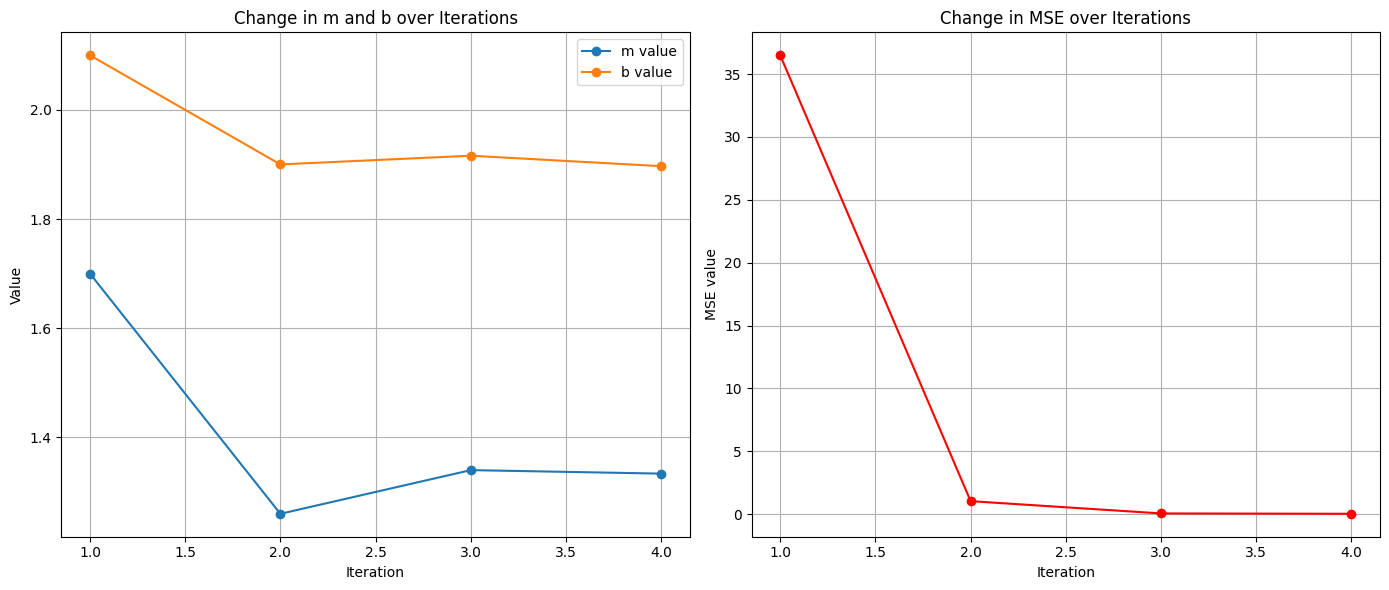

In [ ]:
# Visualize the changes
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot m and b history
iterations = range(1, num_iterations + 1)
axes[0].plot(iterations, m_history, marker='o', linestyle='-', label='m value')
axes[0].plot(iterations, b_history, marker='o', linestyle='-', label='b value')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Value')
axes[0].set_title('Change in m and b over Iterations')
axes[0].legend()
axes[0].grid(True)


# Plot MSE history
axes[1].plot(iterations, mse_history, marker='o', linestyle='-', color='red')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('MSE value')
axes[1].set_title('Change in MSE over Iterations')
axes[1].grid(True)


plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The initial parameters for the linear equation were set to $m=-1$ and $b=1$, with a learning rate ($\alpha$) of 0.1.
*   The gradient descent algorithm was successfully implemented and run for 4 iterations using the data points (1, 3) and (3, 6).
*   Over the 4 iterations, the value of $m$ changed from -1 to approximately 1.334, and the value of $b$ changed from 1 to approximately 1.9.
*   The Mean Squared Error (MSE) decreased over the iterations, indicating that the model was learning and improving its fit to the data.
*   Using the final parameters ($m \approx 1.3336$, $b \approx 1.8968$), the predicted y-values for the input data points were calculated.
*   The changes in $m$, $b$, and MSE over the iterations were successfully visualized using line plots.

### Insights or Next Steps

*   The decrease in MSE over the iterations suggests that the gradient descent process is converging. Running for more iterations could potentially lead to a lower MSE and parameters closer to the optimal values.
*   Evaluating the model's performance on new, unseen data would be a valuable next step to ensure it generalizes well beyond the training data points.
